### Libararies

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os, sys, getpass
user = getpass.getuser()
sys.path.append(f'/home/{user}/codes/hpe_library/')
from lib_import import *
from my_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load dataset

In [4]:
h36m_3d_world, h36m_cam_param = load_h36m()

subject = 'S1'
action = 'Walking'
action_list = h36m_3d_world._data[subject].keys()
pose3d_s1_walking = h36m_3d_world._data[subject][action]['positions'] # 3d skeleton sequence wrt world CS
cam_info_s1_walking = h36m_3d_world._data[subject][action]['cameras']
cam_param_s1_walking = get_cam_param(cam_info_s1_walking, subject, h36m_cam_param)

# camera parameters
W, H = cam_param_s1_walking['54138969']['W'], cam_param_s1_walking['54138969']['H']
cam_54138969_ext = cam_param_s1_walking['54138969']['ext']
cam_54138969_int = cam_param_s1_walking['54138969']['int']
cam_54138969_proj = cam_param_s1_walking['54138969']['proj']
cam_54138969_origin = cam_param_s1_walking['54138969']['C']

# 3d trajectory
torso_trajectory = get_part_traj(pose3d_s1_walking, 'torso')
pelvis_trajectory = get_part_traj(pose3d_s1_walking, 'pelvis')
l_hip_trajectory = get_part_traj(pose3d_s1_walking, 'l_hip')
l_shoulder_trajectory = get_part_traj(pose3d_s1_walking, 'l_shoulder')
r_shoulder_trajectory = get_part_traj(pose3d_s1_walking, 'r_shoulder')
r_hip_trajectory = get_part_traj(pose3d_s1_walking, 'r_hip')
lower_line_trajectory = get_part_traj(pose3d_s1_walking, 'lower_line')

# World frame
world_frame = generate_world_frame()

print(pose3d_s1_walking.shape)

==> Loading 3D data wrt World CS...
(3134, 17, 3)


### Check (new) DH matrix

In [3]:
import sympy as s
from sympy import *
z_rot = s.Matrix([[s.cos('theta'), -s.sin('theta'), 0, 0], 
            [s.sin('theta'), s.cos('theta'), 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1]])
y_rot = s.Matrix([[s.cos('alpha'), 0, -s.sin('alpha'), 0], 
            [0, 1, 0, 0],
            [s.sin('alpha'), 0, s.cos('alpha'), 0],
            [0, 0, 0, 1]])
trans = s.Matrix([[1, 0, 0, 'l'],
            [0, 1, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1]])
z_rot*y_rot*trans


Matrix([
[cos(alpha)*cos(theta), -sin(theta), -sin(alpha)*cos(theta), l*cos(alpha)*cos(theta)],
[sin(theta)*cos(alpha),  cos(theta), -sin(alpha)*sin(theta), l*sin(theta)*cos(alpha)],
[           sin(alpha),           0,             cos(alpha),            l*sin(alpha)],
[                    0,           0,                      0,                       1]])

In [4]:
print(latex(z_rot))
print(latex(y_rot))
print(latex(trans))
print(latex(z_rot*y_rot*trans))

\left[\begin{matrix}\cos{\left(\theta \right)} & - \sin{\left(\theta \right)} & 0 & 0\\\sin{\left(\theta \right)} & \cos{\left(\theta \right)} & 0 & 0\\0 & 0 & 1 & 0\\0 & 0 & 0 & 1\end{matrix}\right]
\left[\begin{matrix}\cos{\left(\alpha \right)} & 0 & - \sin{\left(\alpha \right)} & 0\\0 & 1 & 0 & 0\\\sin{\left(\alpha \right)} & 0 & \cos{\left(\alpha \right)} & 0\\0 & 0 & 0 & 1\end{matrix}\right]
\left[\begin{matrix}1 & 0 & 0 & l\\0 & 1 & 0 & 0\\0 & 0 & 1 & 0\\0 & 0 & 0 & 1\end{matrix}\right]
\left[\begin{matrix}\cos{\left(\alpha \right)} \cos{\left(\theta \right)} & - \sin{\left(\theta \right)} & - \sin{\left(\alpha \right)} \cos{\left(\theta \right)} & l \cos{\left(\alpha \right)} \cos{\left(\theta \right)}\\\sin{\left(\theta \right)} \cos{\left(\alpha \right)} & \cos{\left(\theta \right)} & - \sin{\left(\alpha \right)} \sin{\left(\theta \right)} & l \sin{\left(\theta \right)} \cos{\left(\alpha \right)}\\\sin{\left(\alpha \right)} & 0 & \cos{\left(\alpha \right)} & l \sin{\left(\alph

In [5]:
DH_matrix(radians(45), radians(45), 1)

array([[ 0.5       , -0.70710678, -0.5       ,  0.5       ],
       [ 0.5       ,  0.70710678, -0.5       ,  0.5       ],
       [ 0.70710678,  0.        ,  0.70710678,  0.70710678],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

### Test two link with new DH matrix

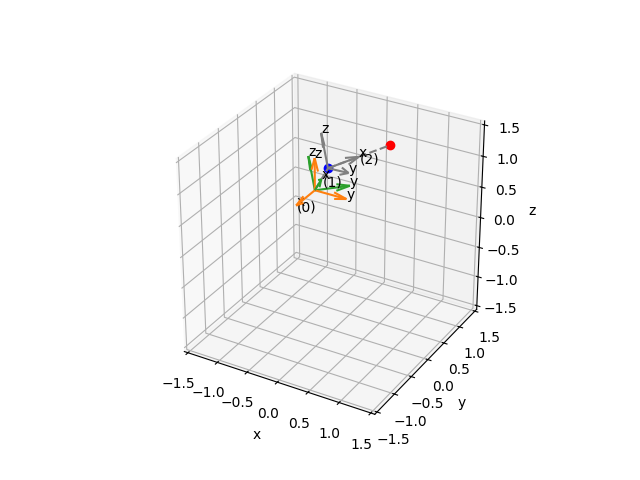

In [3]:
start_point = np.array([0, -0.5, 1])

# initial setting
origin = start_point
Rot_z_minus_90 = Rotation.from_rotvec(-np.pi/2 * np.array([0, 0, 1])).as_matrix()
Rot_y_minus_90 = Rotation.from_rotvec(-np.pi/2 * np.array([0, 1, 0])).as_matrix()
forward = np.array([0, 0, -1]) # x-axis
up = np.array([1, 0, 0]) # z-axis
left = np.cross(up, forward) # y-axis

root_tf = np.eye(4)
root_tf[:3, :3] = Rot_z_minus_90 # Rot_y_90 # frame_vec_to_matrix(forward, left, up) # Rot_z_minus_90
root_tf[:3, 3] = origin

m01 = DH_matrix(theta=radians(45), alpha=radians(45), d=1)
m12 = DH_matrix(theta=radians(45), alpha=radians(0), d=1)
m02 = m01 @ m12
link1_tf = root_tf @ m01
link2_tf = root_tf @ m02
next_point = link1_tf[:3, 3]
final_point = link2_tf[:3, 3]
link1_vec = next_point - start_point
link2_vec = final_point - next_point

root_R = root_tf[:3, :3]
link1_R = link1_tf[:3, :3]
link2_R = link2_tf[:3, :3]
root_frame = generate_dh_frame(origin, root_R.transpose(), '0')
link1_frame1 = generate_dh_frame(start_point, link1_R.transpose(), '1')
link2_frame2 = generate_dh_frame(next_point, link2_R.transpose(), '2')

# -------------------------------------
%matplotlib widget
fig9 = plt.figure(91)
fig9.clear()
ax = fig9.add_subplot(111, projection="3d")
set_xyzlim3d(-1.5, 1.5)
ax.set_aspect('equal', 'box')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

#generate_world_frame().draw3d()
ax.plot(next_point[0], next_point[1], next_point[2], 'ob')
ax.plot(final_point[0], final_point[1], final_point[2], 'or')
root_frame.draw3d(color='tab:orange')
link1_frame1.draw3d(color='tab:green')
link2_frame2.draw3d(color='tab:gray')
ax.plot(*np.c_[start_point, next_point], color="tab:gray", ls='--' )
ax.plot(*np.c_[next_point, final_point], color="tab:gray", ls='--' )

plt.show()

### Test two link model with new DH matrix with GUI

1.0 0.0 0.0
1.0 0.0 0.0


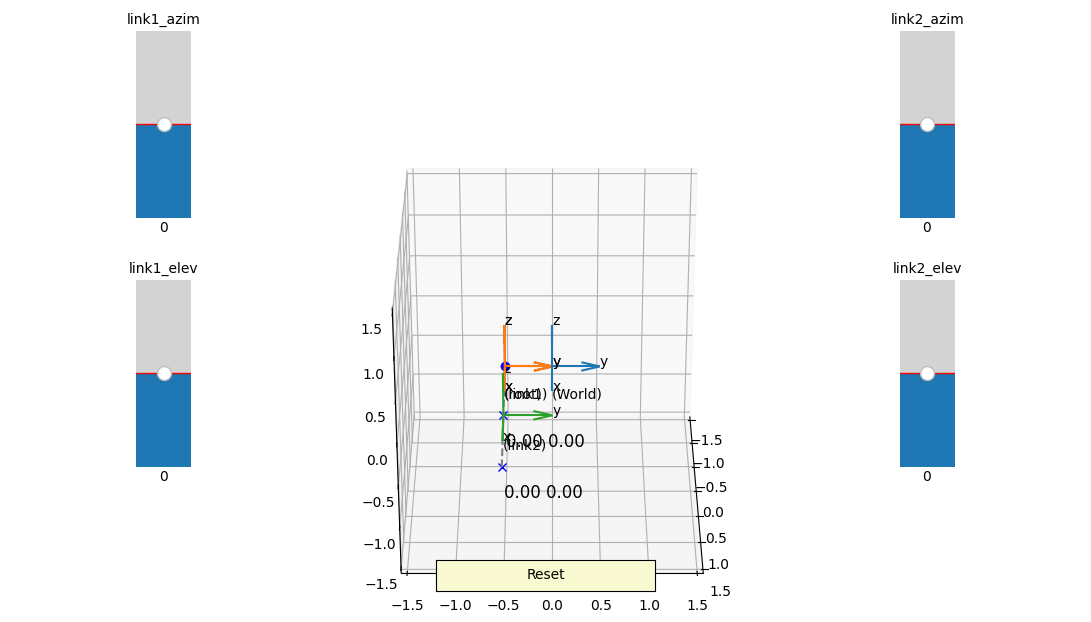

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.widgets import Slider, Button
%matplotlib widget

# plot setting
fig11 = plt.figure(11)
fig11.clear()
ax1 = fig11.add_axes([0, 0, 1, 0.8], projection = '3d')
ax1.view_init(elev=30, azim=0)
ax1.set_aspect('equal', 'box')
ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-1.5, 1.5)
ax1.set_zlim(-1.5, 1.5)

# world frame
world_frame = generate_world_frame()

# GUI setting
ax_link1_azim = fig11.add_axes([0.1, 0.65, 0.1, 0.3])
ax_link1_elev = fig11.add_axes([0.1, 0.25, 0.1, 0.3])
ax_link2_azim = fig11.add_axes([0.8, 0.65, 0.1, 0.3])
ax_link2_elev = fig11.add_axes([0.8, 0.25, 0.1, 0.3])
ax_reset = fig11.add_axes([0.4, 0.05, 0.2, 0.05])

link1_azim_init, link1_elev_init = 0, 0
link2_azim_init, link2_elev_init = 0, 0
link1_length, link2_length = 1, 1

s_link1_azim = Slider(ax = ax_link1_azim, label = 'link1_azim', valmin = -179.99, valmax = 179.99, valinit = link1_azim_init, orientation="vertical")
s_link1_elev = Slider(ax = ax_link1_elev, label = 'link1_elev', valmin = -179.99, valmax = 179.99, valinit = link1_elev_init, orientation="vertical")
s_link2_azim = Slider(ax = ax_link2_azim, label = 'link2_azim', valmin = -179.99, valmax = 179.99, valinit = link2_azim_init, orientation="vertical")
s_link2_elev = Slider(ax = ax_link2_elev, label = 'link2_elev', valmin = -179.99, valmax = 179.99, valinit = link2_elev_init, orientation="vertical")
button = Button(ax_reset, 'Reset', color='lightgoldenrodyellow', hovercolor='0.975')

start_point = np.array([0, -0.5, 0])

# initial setting
origin = start_point
Rot_z_minus_90 = Rotation.from_rotvec(-np.pi/2 * np.array([0, 0, 1])).as_matrix()
root_tf = np.eye(4)
#root_tf[:3, :3] = Rot_z_minus_90
root_tf[:3, 3] = origin
link1_length, link2_length = 1, 1

l1_prev_azim = 0
l1_prev_elev = 0
l2_prev_azim = 0
l2_prev_elev = 0

def update(val):
    global l1_prev_azim, l1_prev_elev, l2_prev_azim, l2_prev_elev

    # update two link model
    link1_azim = s_link1_azim.val
    link1_elev = s_link1_elev.val
    link2_azim = s_link2_azim.val
    link2_elev = s_link2_elev.val
    output = generate_two_link(link1_azim, link1_elev, link2_azim, link2_elev, l1=link1_length, l2=link2_length, root_tf=root_tf, degrees=True)
    link1_origin, link2_origin, terminal_origin, root_R, link1_R, link2_R, root_frame, link1_frame, link2_frame = output
    
    # link vector
    link1_vec = link2_origin - link1_origin # expressed wrt world frame
    link2_vec = terminal_origin - link2_origin # expressed wrt world frame
    
    # calculate azimuth and elevation
    ik_l1_azim, ik_l1_elev = get_optimal_azimuth_elevation(link1_vec, root_R, l1_prev_azim, l1_prev_elev, degrees=True)
    ik_l2_azim, ik_l2_elev = get_optimal_azimuth_elevation(link2_vec, link1_R, l2_prev_azim, l2_prev_elev, degrees=True)

    # update previous values
    l1_prev_azim, l1_prev_elev = ik_l1_azim, ik_l1_elev
    l2_prev_azim, l2_prev_elev = ik_l2_azim, ik_l2_elev
     
    # plot setting
    clear_axes(ax1)
    plt.sca(ax1)
    
    # plot
    world_frame.draw3d() # world frame
    
    # draw frame
    root_frame.draw3d(color='tab:red')
    link1_frame.draw3d(color='tab:orange')
    link2_frame.draw3d(color='tab:green')
    
    # draw keypoint
    ax1.plot(link1_origin[0], link1_origin[1], link1_origin[2], 'ob')
    ax1.plot(link2_origin[0], link2_origin[1], link2_origin[2], 'xb')
    ax1.plot(terminal_origin[0], terminal_origin[1], terminal_origin[2], 'xb')
    
    # draw link
    ax1.plot(*np.c_[link1_origin, link1_origin+link1_vec], color="tab:gray", ls='--') 
    ax1.plot(*np.c_[link2_origin, terminal_origin], color="tab:gray", ls='--')

    # print IK results
    ax1.text(link1_origin[0], link1_origin[1], link1_origin[2]-1, f'{ik_l1_azim:.2f} {ik_l1_elev:.2f}', fontsize=12) # link1 ik result
    ax1.text(link2_origin[0], link2_origin[1], link2_origin[2]-1, f'{ik_l2_azim:.2f} {ik_l2_elev:.2f}', fontsize=12) # link2 ik result
    #ax1.text(link2_origin[0], link2_origin[1], link2_origin[2]-2, '{:.2f} {:.2f} {:.2f}'.format(*list(link2_vec_wrt_link1)), fontsize=12) # link2 vec wrt link1 frame
            
def reset(event):
    s_link1_azim.reset()
    s_link1_elev.reset()
    s_link2_azim.reset()
    s_link2_elev.reset()
    
s_link1_azim.on_changed(update)
s_link1_elev.on_changed(update)
s_link2_azim.on_changed(update)
s_link2_elev.on_changed(update)
 
button.on_clicked(reset)
update(0)

plt.show()

### Appendage Model - update_link_from_angle

[[ 2.22044605e-16  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -5.00000000e-01]
 [-1.00000000e+00  0.00000000e+00  2.22044605e-16  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


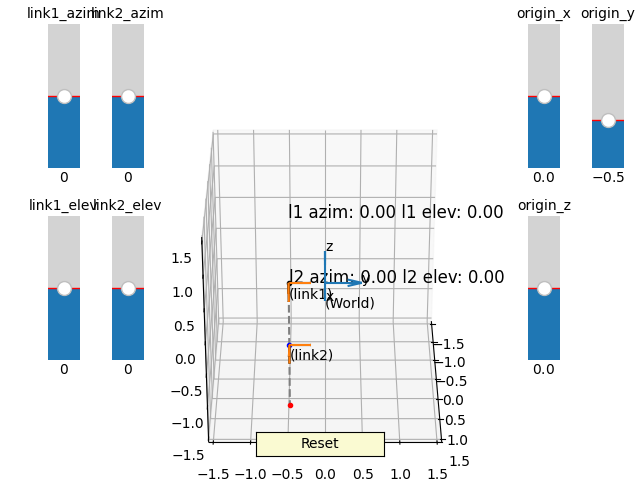

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.widgets import Slider, Button
%matplotlib widget

# plot setting
fig11 = plt.figure(12)
fig11.clear()
ax1 = fig11.add_axes([0, 0, 1, 0.8], projection = '3d')
ax1.view_init(elev=30, azim=0)
ax1.set_aspect('equal', 'box')
ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-1.5, 1.5)
ax1.set_zlim(-1.5, 1.5)

# world frame
world_frame = generate_world_frame()

# GUI setting
ax_link1_azim = fig11.add_axes([0.05, 0.65, 0.1, 0.3])
ax_link1_elev = fig11.add_axes([0.05, 0.25, 0.1, 0.3])
ax_link2_azim = fig11.add_axes([0.15, 0.65, 0.1, 0.3])
ax_link2_elev = fig11.add_axes([0.15, 0.25, 0.1, 0.3])
ax_origin_x   = fig11.add_axes([0.8, 0.65, 0.1, 0.3])
ax_origin_y   = fig11.add_axes([0.9, 0.65, 0.1, 0.3])
ax_origin_z   = fig11.add_axes([0.8, 0.25, 0.1, 0.3])
ax_reset = fig11.add_axes([0.4, 0.05, 0.2, 0.05])

link1_azim_init, link1_elev_init = 0, 0
link2_azim_init, link2_elev_init = 0, 0
link1_length, link2_length = 1, 1

s_link1_azim = Slider(ax = ax_link1_azim, label = 'link1_azim', valmin = -179.99, valmax = 179.99, valinit = link1_azim_init, orientation="vertical")
s_link1_elev = Slider(ax = ax_link1_elev, label = 'link1_elev', valmin = -179.99, valmax = 179.99, valinit = link1_elev_init, orientation="vertical")
s_link2_azim = Slider(ax = ax_link2_azim, label = 'link2_azim', valmin = -179.99, valmax = 179.99, valinit = link2_azim_init, orientation="vertical")
s_link2_elev = Slider(ax = ax_link2_elev, label = 'link2_elev', valmin = -179.99, valmax = 179.99, valinit = link2_elev_init, orientation="vertical")
s_origin_x   = Slider(ax = ax_origin_x, label = 'origin_x', valmin = -1.5, valmax = 1.5, valinit = 0, orientation="vertical")
s_origin_y   = Slider(ax = ax_origin_y, label = 'origin_y', valmin = -1.5, valmax = 1.5, valinit = -0.5, orientation="vertical")
s_origin_z   = Slider(ax = ax_origin_z, label = 'origin_z', valmin = -1.5, valmax = 1.5, valinit = 0, orientation="vertical")
button = Button(ax_reset, 'Reset', color='lightgoldenrodyellow', hovercolor='0.975')

start_point = np.array([0, -0.5, 0])

# initial setting
origin = start_point
Rot_z_minus_90 = Rotation.from_rotvec(-np.pi/2 * np.array([0, 0, 1])).as_matrix()
Rot_y_90 = Rotation.from_rotvec(np.pi/2 * np.array([0, 1, 0])).as_matrix()
root_tf = np.eye(4)
root_tf[:3, :3] = Rot_y_90
root_tf[:3, 3] = origin
link1_length, link2_length = 1, 1


l1_prev_azim = 0
l1_prev_elev = 0
l2_prev_azim = 0
l2_prev_elev = 0

# generate appendage 
appendage = Appendage(link1_length, link2_length, link1_azim_init, link1_elev_init, link2_azim_init, link2_elev_init, degrees=True, root_tf=root_tf)

def update(val):
    global l1_prev_azim, l1_prev_elev, l2_prev_azim, l2_prev_elev

    # update two link model
    link1_azim = s_link1_azim.val
    link1_elev = s_link1_elev.val
    link2_azim = s_link2_azim.val
    link2_elev = s_link2_elev.val
    origin_x = s_origin_x.val
    origin_y = s_origin_y.val
    origin_z = s_origin_z.val
    #root_tf = np.eye(4)
    root_tf[:3, 3] = np.array([origin_x, origin_y, origin_z])
    appendage.update_link_from_angle(link1_azim, link1_elev, link2_azim, link2_elev, root_tf=root_tf, degrees=True)
    
    # calculate azimuth and elevation
    ik_l1_azim, ik_l1_elev = get_optimal_azimuth_elevation(appendage.link1_vec, appendage.root_R, l1_prev_azim, l1_prev_elev, degrees=True)
    ik_l2_azim, ik_l2_elev = get_optimal_azimuth_elevation(appendage.link2_vec, appendage.link1_R, l2_prev_azim, l2_prev_elev, degrees=True)

    # update previous values
    l1_prev_azim, l1_prev_elev = ik_l1_azim, ik_l1_elev
    l2_prev_azim, l2_prev_elev = ik_l2_azim, ik_l2_elev
     
    # plot setting
    clear_axes(ax1)
    plt.sca(ax1)

    # plot
    world_frame.draw3d() # world frame
    appendage.draw(ax1, draw_frame=True, scale=0.3, show_name=True)

    # print IK results
    ax1.text(appendage.link1_origin[0], appendage.link1_origin[1], appendage.link1_origin[2]+1, f'l1 azim: {ik_l1_azim:.2f} l1 elev: {ik_l1_elev:.2f}', fontsize=12) # link1 ik result
    ax1.text(appendage.link2_origin[0], appendage.link2_origin[1], appendage.link2_origin[2]+1, f'l2 azim: {ik_l2_azim:.2f} l2 elev: {ik_l2_elev:.2f}', fontsize=12) # link2 ik result
            
def reset(event):
    s_link1_azim.reset()
    s_link1_elev.reset()
    s_link2_azim.reset()
    s_link2_elev.reset()
    s_origin_x.reset()
    s_origin_y.reset()
    s_origin_z.reset()
    
s_link1_azim.on_changed(update)
s_link1_elev.on_changed(update)
s_link2_azim.on_changed(update)
s_link2_elev.on_changed(update)
s_origin_x.on_changed(update)
s_origin_y.on_changed(update)
s_origin_z.on_changed(update)
 
button.on_clicked(reset)
update(0)

plt.show()

### Appendage - update_link_from_vector

d1 0.0, d2 0.07753807805382895 azim1 0.00, elev1 0.00, azim2 -10313.24, elev2 10313.24 prev_azim 0.00, prev_elev 0.00
d1 0.0, d2 0.07753807805382895 azim1 0.00, elev1 0.00, azim2 -10313.24, elev2 10313.24 prev_azim 0.00, prev_elev 0.00


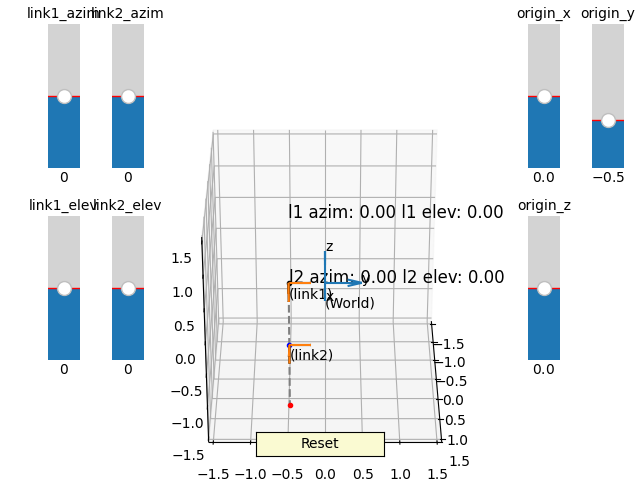

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.widgets import Slider, Button
%matplotlib widget

# plot setting
fig11 = plt.figure(13)
fig11.clear()
ax1 = fig11.add_axes([0, 0, 1, 0.8], projection = '3d')
ax1.view_init(elev=30, azim=0)
ax1.set_aspect('equal', 'box')
ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-1.5, 1.5)
ax1.set_zlim(-1.5, 1.5)

# world frame
world_frame = generate_world_frame()

# GUI setting
ax_link1_azim = fig11.add_axes([0.05, 0.65, 0.1, 0.3])
ax_link1_elev = fig11.add_axes([0.05, 0.25, 0.1, 0.3])
ax_link2_azim = fig11.add_axes([0.15, 0.65, 0.1, 0.3])
ax_link2_elev = fig11.add_axes([0.15, 0.25, 0.1, 0.3])
ax_origin_x   = fig11.add_axes([0.8, 0.65, 0.1, 0.3])
ax_origin_y   = fig11.add_axes([0.9, 0.65, 0.1, 0.3])
ax_origin_z   = fig11.add_axes([0.8, 0.25, 0.1, 0.3])
ax_reset = fig11.add_axes([0.4, 0.05, 0.2, 0.05])

link1_azim_init, link1_elev_init = 0, 0
link2_azim_init, link2_elev_init = 0, 0
link1_length, link2_length = 1, 1

s_link1_azim = Slider(ax = ax_link1_azim, label = 'link1_azim', valmin = -179.99, valmax = 179.99, valinit = link1_azim_init, orientation="vertical")
s_link1_elev = Slider(ax = ax_link1_elev, label = 'link1_elev', valmin = -179.99, valmax = 179.99, valinit = link1_elev_init, orientation="vertical")
s_link2_azim = Slider(ax = ax_link2_azim, label = 'link2_azim', valmin = -179.99, valmax = 179.99, valinit = link2_azim_init, orientation="vertical")
s_link2_elev = Slider(ax = ax_link2_elev, label = 'link2_elev', valmin = -179.99, valmax = 179.99, valinit = link2_elev_init, orientation="vertical")
s_origin_x   = Slider(ax = ax_origin_x, label = 'origin_x', valmin = -1.5, valmax = 1.5, valinit = 0, orientation="vertical")
s_origin_y   = Slider(ax = ax_origin_y, label = 'origin_y', valmin = -1.5, valmax = 1.5, valinit = -0.5, orientation="vertical")
s_origin_z   = Slider(ax = ax_origin_z, label = 'origin_z', valmin = -1.5, valmax = 1.5, valinit = 0, orientation="vertical")
button = Button(ax_reset, 'Reset', color='lightgoldenrodyellow', hovercolor='0.975')

start_point = np.array([0, -0.5, 0])

# initial setting
origin = start_point
Rot_z_minus_90 = Rotation.from_rotvec(-np.pi/2 * np.array([0, 0, 1])).as_matrix()
Rot_y_90 = Rotation.from_rotvec(np.pi/2 * np.array([0, 1, 0])).as_matrix()
root_tf = np.eye(4)
root_tf[:3, :3] = Rot_y_90
root_tf[:3, 3] = origin
link1_length, link2_length = 1, 1


l1_prev_azim = 0
l1_prev_elev = 0
l2_prev_azim = 0
l2_prev_elev = 0

# generate appendage 
appendage = Appendage(link1_length, link2_length, link1_azim_init, link1_elev_init, link2_azim_init, link2_elev_init, degrees=True, root_tf=root_tf)

def update(val):
    global l1_prev_azim, l1_prev_elev, l2_prev_azim, l2_prev_elev

    # update two link model
    link1_azim = s_link1_azim.val
    link1_elev = s_link1_elev.val
    link2_azim = s_link2_azim.val
    link2_elev = s_link2_elev.val
    origin_x = s_origin_x.val
    origin_y = s_origin_y.val
    origin_z = s_origin_z.val
    #root_tf = np.eye(4)
    root_tf[:3, 3] = np.array([origin_x, origin_y, origin_z])

    link1_tf, link1_dh_mat = build_dh_frame(link1_azim, link1_elev, link1_length, root_tf, degrees=True)
    link2_tf, link2_dh_mat = build_dh_frame(link2_azim, link2_elev, link2_length, link1_tf, degrees=True)


    link1_origin = root_tf[:3, 3]
    link2_origin = link1_tf[:3, 3]
    terminal_origin = link2_tf[:3, 3]

    link1_vec_global = link2_origin - link1_origin
    link2_vec_global = terminal_origin - link2_origin

    # appendage.update_link_from_angle(link1_azim, link1_elev, link2_azim, link2_elev, root_tf=root_tf, degrees=True)

    appendage.update_link_from_vector(link1_vec_global, link2_vec_global, root_tf)
    
    # # calculate azimuth and elevation
    # ik_l1_azim, ik_l1_elev = get_optimal_azimuth_elevation(appendage.link1_vec, appendage.root_R, l1_prev_azim, l1_prev_elev, degrees=True)
    # ik_l2_azim, ik_l2_elev = get_optimal_azimuth_elevation(appendage.link2_vec, appendage.link1_R, l2_prev_azim, l2_prev_elev, degrees=True)

    # update previous values
    # l1_prev_azim, l1_prev_elev = ik_l1_azim, ik_l1_elev
    # l2_prev_azim, l2_prev_elev = ik_l2_azim, ik_l2_elev
    ik_l1_azim, ik_l1_elev = appendage.link1_azim, appendage.link1_elev
    ik_l2_azim, ik_l2_elev = appendage.link2_azim, appendage.link2_elev
     
    # plot setting
    clear_axes(ax1)
    plt.sca(ax1)

    # plot
    world_frame.draw3d() # world frame
    #ax1.plot(*np.c_[link1_origin, link2_origin], color="tab:gray", ls='--') # link1
    #ax1.plot(link2_origin[0], link2_origin[1], link2_origin[2], '.b') # link2 origin
    #ax1.plot(*np.c_[link2_origin, terminal_origin], color="tab:gray", ls='--') # link2
    #ax1.plot(terminal_origin[0], terminal_origin[1], terminal_origin[2], '.r') # terminal origin
    appendage.draw(ax1, draw_frame=True, scale=0.3, show_name=True)

    # print IK results
    #ax1.text(link1_origin[0], link1_origin[1], link1_origin[2]+1, f'{link1_vec_global[0]:.2f} {link1_vec_global[1]:.2f} {link1_vec_global[2]:.2f}', fontsize=12) # link1 ik result
    #ax1.text(link2_origin[0], link2_origin[1], link2_origin[2]+1, f'{link2_vec_global[0]:.2f} {link2_vec_global[1]:.2f} {link2_vec_global[2]:.2f}', fontsize=12) # link2 ik result
    ax1.text(appendage.link1_origin[0], appendage.link1_origin[1], appendage.link1_origin[2]+1, f'l1 azim: {ik_l1_azim:.2f} l1 elev: {ik_l1_elev:.2f}', fontsize=12) # link1 ik result
    ax1.text(appendage.link2_origin[0], appendage.link2_origin[1], appendage.link2_origin[2]+1, f'l2 azim: {ik_l2_azim:.2f} l2 elev: {ik_l2_elev:.2f}', fontsize=12) # link2 ik result
            
def reset(event):
    s_link1_azim.reset()
    s_link1_elev.reset()
    s_link2_azim.reset()
    s_link2_elev.reset()
    s_origin_x.reset()
    s_origin_y.reset()
    s_origin_z.reset()
    
s_link1_azim.on_changed(update)
s_link1_elev.on_changed(update)
s_link2_azim.on_changed(update)
s_link2_elev.on_changed(update)
s_origin_x.on_changed(update)
s_origin_y.on_changed(update)
s_origin_z.on_changed(update)
 
button.on_clicked(reset)
update(0)

plt.show()

### DH model

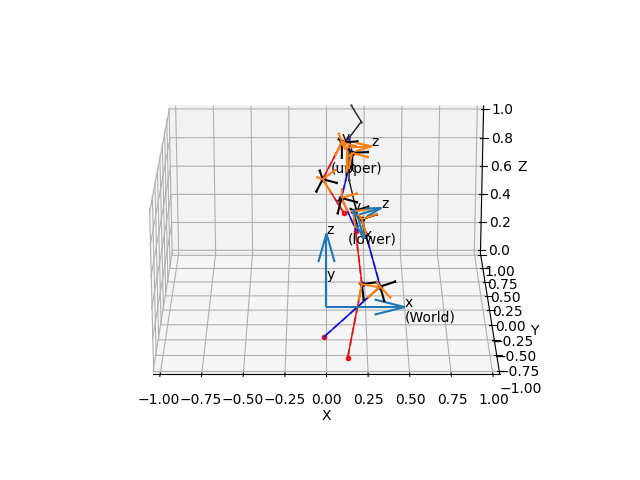

In [23]:
ref_pose = pose3d_s1_walking[500].copy()
dh_model = DHModel(ref_pose, forward_dir='-z')
dh_model.update_dh_model_from_pose(ref_pose)

# # lower frame
# lower_origin, lower_frame_R = get_lower_torso_frame_from_pose(ref_pose)
# lower_frame = generate_vis_frame_from_R(lower_origin, lower_frame_R, name='lower')

# # upper frame
# upper_origin, upper_frame_R = get_upper_torso_frame_from_pose(ref_pose)
# upper_frame = generate_vis_frame_from_R(upper_origin, upper_frame_R, name='upper')

# plot
%matplotlib widget
fig = plt.figure(50)
fig.clear()
lim=1
ax = axes_3d(fig, rect=[0, 0, 1, 1], xlim=(-lim, lim), ylim=(-lim, lim), zlim=(0, lim), view=(20, -90))
dh_model.draw(ax, draw_frame=True, show_axis=False, scale=0.1, fontsize=5)
draw_3d_pose(ax, ref_pose)
world_frame.draw3d()
plt.show()

In [24]:
%matplotlib widget
fig = plt.figure(17)
fig.clear()
ax = axes_3d(fig, rect=[0, 0, 1, 1], xlim=(-2, 2), ylim=(-2, 2), zlim=(0, 2), view=(20, -90))

init_pose_3d = pose3d_s1_walking[0]
dh_model = DHModel(init_pose_3d, forward_dir='-z')
videowriter = imageio.get_writer('/home/hrai/codes/MotionBERT/custom_codes/DHDST/dh_test_h36m_pose_walking.mp4', fps=30)
mpjpe = 0
for frame in tqdm(range(500)): # tqdm(range(len(pose3d_s1_walking))):
    pose_3d = pose3d_s1_walking[frame]
    #dh_model.update_dh_model_from_pose(pose_3d)
    dh_model = DHModel(pose_3d, forward_dir='-z')
    mpjpe += dh_model.mpjpe(pose_3d)
    # plot
    clear_axes(ax)
    dh_model.draw(ax, draw_frame=True, scale=0.1, fontsize=5)
    draw_3d_pose(ax, pose_3d)
    #plt.savefig('/home/hrai/codes/PoseAdaptor/dh_test/dh_test{}.png'.format(frame), dpi=300)
    #plt.show()
    canvas = FigureCanvas(fig)
    canvas.draw()
    image_from_plot = np.array(canvas.renderer._renderer)
    image_from_plot = cv2.cvtColor(image_from_plot, cv2.COLOR_RGB2BGR)           
    videowriter.append_data(image_from_plot)
    #break
    
videowriter.close()
print(mpjpe/len(pose3d_s1_walking))

  0%|          | 0/500 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (444, 333) to (448, 336) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5b18640] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 500/500 [00:31<00:00, 15.78it/s]

2.293393093774177e-09


In [39]:
dh_model.get_dh_angles(by_dict=True, degrees=True)

{'h_l1_yaw': 163.62903356656219,
 'h_l1_pitch': 40.560201422233824,
 'ra_l1_yaw': -24.819167763232716,
 'ra_l1_pitch': -18.79588338181483,
 'ra_l2_yaw': 47.67632362906843,
 'ra_l2_pitch': 37.41656451745826,
 'la_l1_yaw': 21.06081994364713,
 'la_l1_pitch': -20.71005591613579,
 'la_l2_yaw': -27.883397633737232,
 'la_l2_pitch': 50.09862481091023,
 'rl_l1_yaw': 5.788862438356396,
 'rl_l1_pitch': -0.1859145932748795,
 'rl_l2_yaw': 1.903877179707648,
 'rl_l2_pitch': -66.29380833578531,
 'll_l1_yaw': -9.675377662964463,
 'll_l1_pitch': -8.805753538275917,
 'll_l2_yaw': 2.9435835143312645,
 'll_l2_pitch': -17.368408042626164}

### Test Batch Appendage model

In [6]:
pose3d_s1_walking[:2].shape

(2, 17, 3)

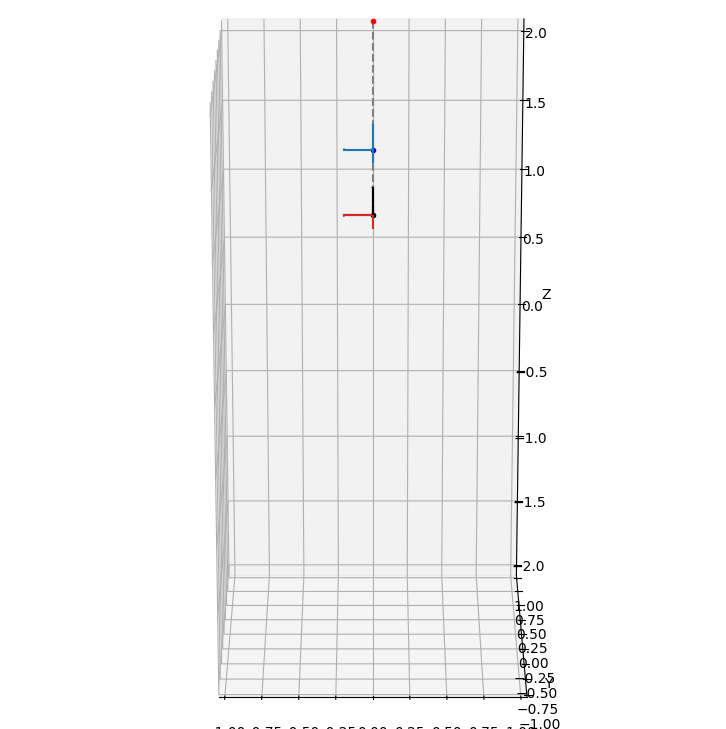

In [109]:
batch_size = 1
num_frames = 243
data_type = torch.float32
device = 'cuda'

batch_link1_length     = torch.ones(batch_size, num_frames) * 0.5
batch_link2_length     = torch.ones(batch_size, num_frames)
batch_link1_azim_init   = torch.ones(batch_size, num_frames) * 45
batch_link1_elev_init = torch.ones(batch_size, num_frames) * 0
batch_link2_azim_init   = torch.ones(batch_size, num_frames) * 0
batch_link2_elev_init = torch.ones(batch_size, num_frames) * 0



origin = np.array([0, 0, 1])
forward = np.array([0, 0, -1]) # x-axis
up = np.array([1, 0, 0]) # z-axis
left = np.cross(up, forward) # y-axis
root_R = frame_vec_to_matrix(forward, left, up)

root_tf = np.eye(4)
root_tf[:3, 3] = origin
root_tf[:3, :3] = root_R

batch_root_tf = torch.tensor(root_tf, dtype=torch.float32).unsqueeze(0).unsqueeze(0).repeat(batch_size, num_frames, 1, 1)


batch_appendage = BatchAppendage(batch_link1_length, batch_link2_length, batch_link1_azim_init, batch_link1_elev_init, batch_link2_azim_init, batch_link2_elev_init, 
                                 degrees=True, batch_root_tf=batch_root_tf, device='cuda')

%matplotlib widget
fig = plt.figure(84)
fig.clear()
ax = axes_3d(fig, rect=[0, 0, 1, 1], xlim=(-1, 1), ylim=(-1, 1), zlim=(-2, 2), view=(20, -90))
batch_num = 0
frame_num = -1
batch_appendage.draw(ax, batch_num, frame_num, draw_frame=True, scale=0.2, fontsize=5)
plt.show()

In [17]:
root_tf

array([[ 0. ,  0. , -1. ,  0. ],
       [ 0. ,  1. ,  0. ,  0. ],
       [ 1. ,  0. ,  0. ,  0.5],
       [ 0. ,  0. ,  0. ,  1. ]])

### Test Batch DH model

tensor(4.1663e-08, device='cuda:0')
tensor(4.2376e-08, device='cuda:0')
tensor([-0.3687,  0.2051,  0.0858,  0.1900,  0.1930, -0.2390, -0.3894,  0.6386,
         0.3390, -0.0810, -0.1181, -0.2548,  0.0485,  0.0630,  0.5594, -1.2376],
       device='cuda:0')
tensor([-0.3687,  0.2051,  0.0858,  0.1900,  0.1930, -0.2390, -0.3894,  0.6386,
         0.3390, -0.0810, -0.1181, -0.2548,  0.0485,  0.0630,  0.5594, -1.2376],
       device='cuda:0')


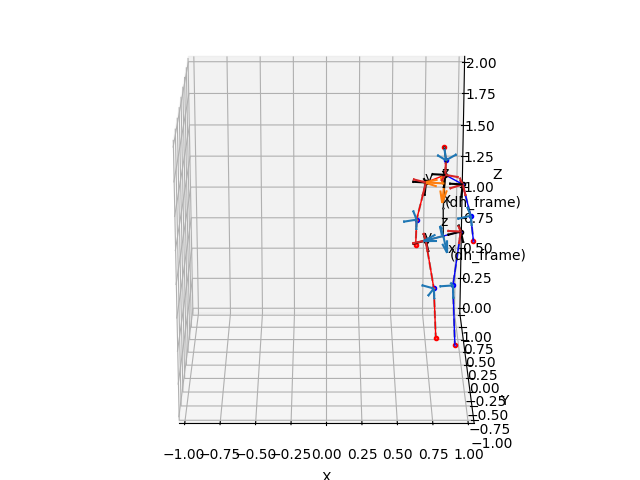

In [224]:
i = 0
num_frames = len(pose3d_s1_walking)
batch_pose_3d = pose3d_s1_walking[num_frames*i:num_frames*(i+1)].reshape(1, num_frames, 17, 3).copy()

Rot_z_90 = Rotation.from_rotvec(np.pi/2 * np.array([0, 0, 1])).as_matrix()
Rot_y_90 = Rotation.from_rotvec(np.pi/2 * np.array([0, 1, 0])).as_matrix()
batch_R = torch.tensor(Rot_z_90, dtype=torch.float32).unsqueeze(0).unsqueeze(0).repeat(batch_size, num_frames, 1, 1)
batch_pose_3d_rotated = rotate_pose_by_R_for_batch(batch_pose_3d, batch_R)

batch_dh_model = BatchDHModel(batch_pose_3d, batch_size=1, num_frames=num_frames, head=True)
batch_dh_model_rotated = BatchDHModel(batch_pose_3d_rotated, batch_size=1, num_frames=num_frames, head=True)
print(batch_dh_model.batch_mpjpe(batch_pose_3d))
print(batch_dh_model_rotated.batch_mpjpe(batch_pose_3d_rotated))

frame_num = 1000
%matplotlib widget
fig = plt.figure(83)
fig.clear()
ax = axes_3d(fig, rect=[0, 0, 1, 1], xlim=(-1, 1), ylim=(-1, 1), zlim=(0, 2), view=(20, -90))
batch_dh_model.draw(ax, 0, frame_num, draw_frame=True, show_name=False, draw_gt=True)
print(batch_dh_model.get_batch_appendage_angles(by_dict=False, degrees=False)[0, frame_num])
print(batch_dh_model_rotated.get_batch_appendage_angles(by_dict=False, degrees=False)[0, frame_num])
plt.show()

In [8]:
batch_dh_model.get_batch_pose_3d().shape

torch.Size([1, 3134, 17, 3])

In [222]:
a = torch.split(torch.ones([8, 243, 2]), [1, 1], dim=-1)
a[0].shape, a[1].shape

(torch.Size([8, 243, 1]), torch.Size([8, 243, 1]))

In [221]:
len(a)

4

In [212]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import imageio

videowriter = imageio.get_writer('/home/hrai/codes/MotionBERT/custom_codes/DHDST/test_batch_dh_model.mp4', fps=30)

stride = 1
fig = plt.figure(400, figsize=(10, 10))
fig.clear()
ax = axes_3d(fig, rect=[0, 0, 1, 1], xlim=(-1, 1), ylim=(-1, 1), zlim=(0, 2), view=(20, -90))
for frame in tqdm(range(0, 500, stride)):
    clear_axes(ax)
    batch_dh_model.draw(ax, 0, frame, draw_frame=True, draw_gt=True)
    
    canvas = FigureCanvas(fig)
    canvas.draw()
    image_from_plot = np.array(canvas.renderer._renderer)
    image_from_plot = cv2.cvtColor(image_from_plot, cv2.COLOR_RGB2BGR)
    videowriter.append_data(image_from_plot)
videowriter.close()

100%|██████████| 500/500 [00:36<00:00, 13.63it/s]


In [156]:
batch_dh_model.get_batch_appendage_angles(by_dict=False, degrees=True).shape, batch_dh_model.get_batch_appendage_angles(by_dict=True, degrees=True)['ra_l1_azim'].shape

(torch.Size([1, 3134, 16]), torch.Size([1, 3134]))

In [157]:
batch_dh_model.get_batch_appendage_angles(by_dict=False, degrees=True).shape, batch_dh_model.get_batch_appendage_angles(by_dict=True, degrees=True)['ra_l1_azim'].shape

(torch.Size([1, 3134, 16]), torch.Size([1, 3134]))